In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet
from datetime import datetime
from scipy import stats
import researchpy as rp
from scipy.stats import levene



warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [3]:
df = pd.read_csv("data/01_bikes_registrados.csv", index_col = 0 )
df.head()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
0,1,2018-01-01,winter,0,1,1,1,NO,2,14.110847,18.18125,80.5833,10.749882,654
1,2,2018-01-02,winter,0,1,0,2,SI,2,14.902598,17.68695,69.6087,16.652113,670
2,3,2018-01-03,winter,0,1,0,3,SI,1,8.050924,9.47025,43.7273,16.636703,1229
3,4,2018-01-04,winter,0,1,0,4,SI,1,8.200000,10.60610,59.0435,10.739832,1454
4,5,2018-01-05,winter,0,1,0,5,SI,1,9.305237,11.46350,43.6957,12.522300,1518


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   registro           730 non-null    int64  
 1   fecha              730 non-null    object 
 2   estacion           730 non-null    object 
 3   año                730 non-null    int64  
 4   mes                730 non-null    int64  
 5   vacaciones         730 non-null    int64  
 6   dia_semana         730 non-null    int64  
 7   laborable          730 non-null    object 
 8   clima              730 non-null    int64  
 9   temperatura        730 non-null    float64
 10  sensacion_termica  730 non-null    float64
 11  humedad            730 non-null    float64
 12  viento             730 non-null    float64
 13  registrados        730 non-null    int64  
dtypes: float64(4), int64(7), object(3)
memory usage: 85.5+ KB


In [5]:
df.shape

(730, 14)

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

registro             0
fecha                0
estacion             0
año                  0
mes                  0
vacaciones           0
dia_semana           0
laborable            0
clima                0
temperatura          0
sensacion_termica    0
humedad              0
viento               0
registrados          0
dtype: int64

In [22]:
df["vacaciones"] = df["vacaciones"].astype("category")

In [8]:
def detectar_outliers(lista_columnas, dataframe):
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        # calculamos los límites
        outlier_step = 1.5 * IQR
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila.
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    return dicc_indices

In [23]:
numericas = df.select_dtypes(include = np.number)
columnas = numericas.columns

In [10]:
indices = detectar_outliers(columnas, numericas)

In [21]:
out_registrados = indices["viento"]

Detectamos que en viento y humedad tenemos 

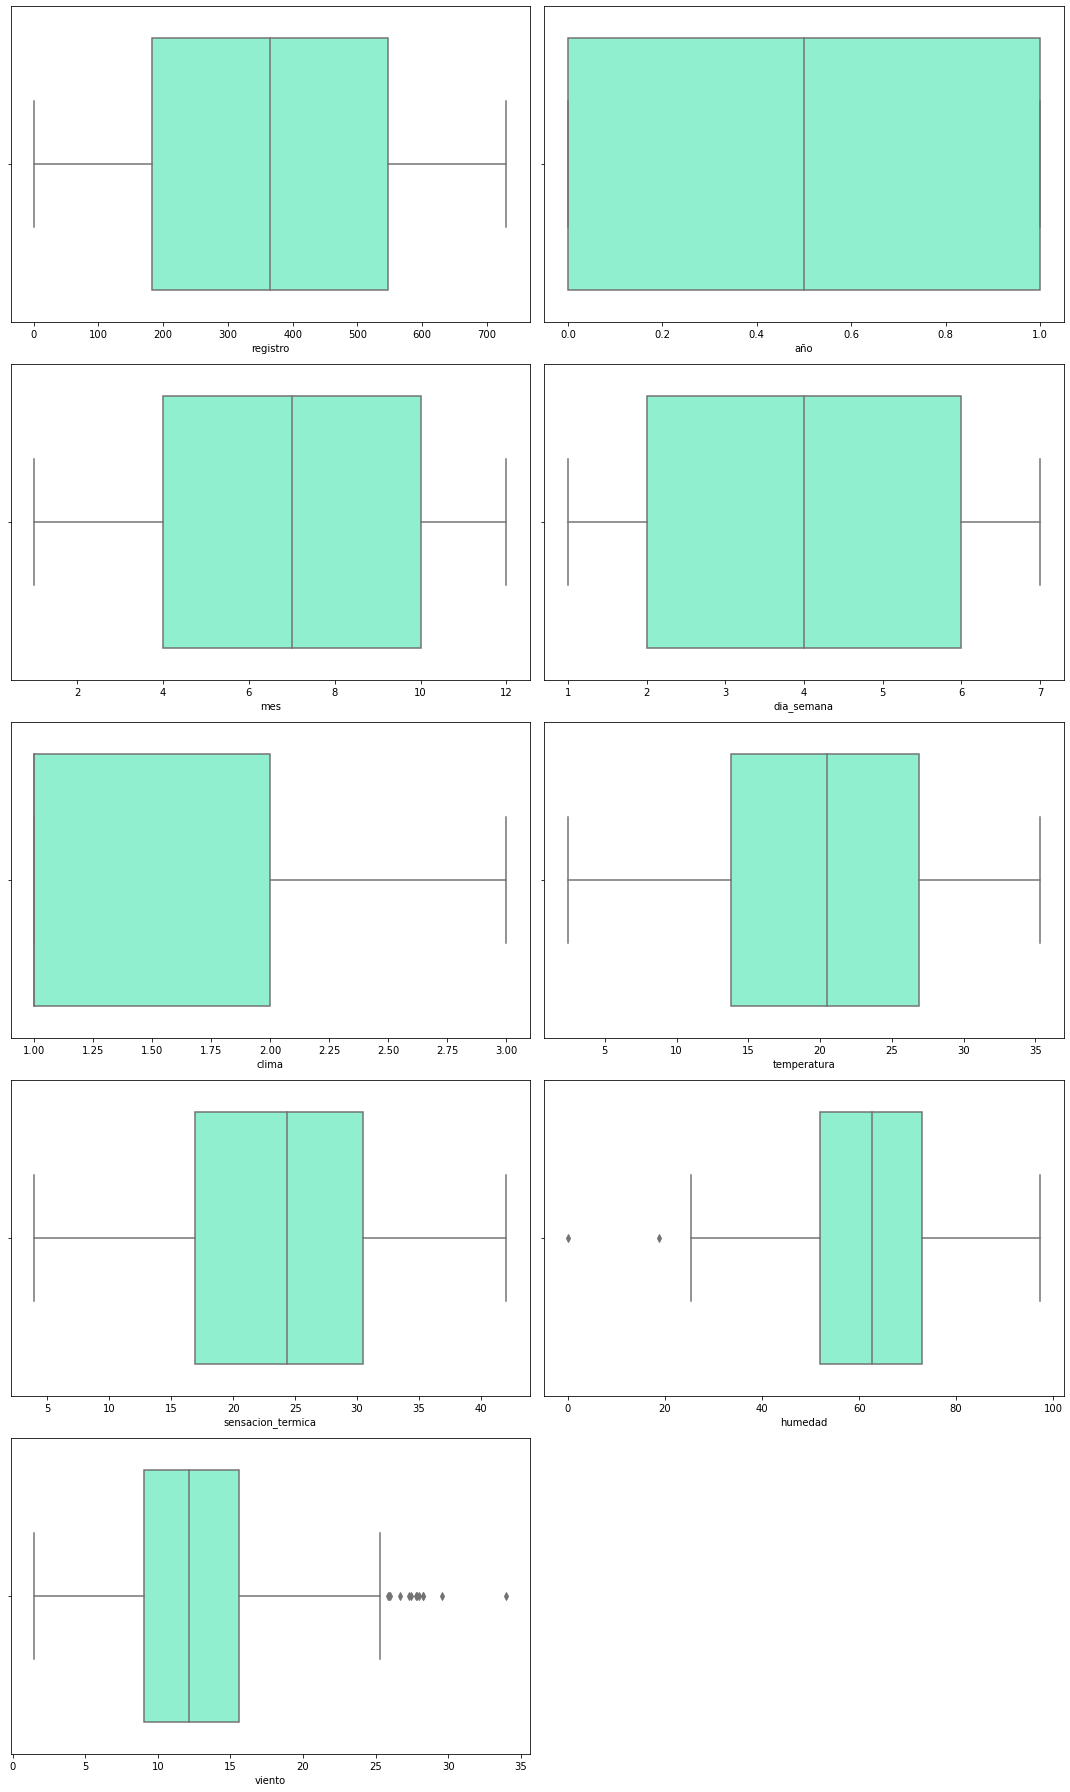

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(15,25))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); # para trazar una línea de densidad

    
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()


Seria interesante ver que que tienen en común los días en los que los casuales alquilan muchas más bicis

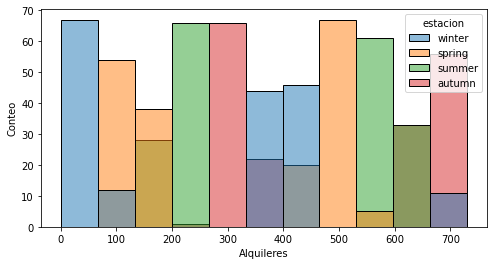

In [29]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='registro', data = df, hue = 'estacion')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()


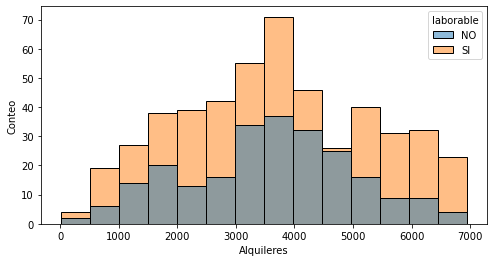

In [31]:
plt.figure(figsize =(8,4))

fig = sns.histplot(x='registrados', data = df, hue = 'laborable')

# establecemos el nombre de los ejes, pero recordad que esto no es obligatorio ya que Seaborn nos los genera automaticamente
fig.set(ylabel='Conteo', xlabel = 'Alquileres')

# Ponemos título a  la gráfica
fig.set_title('')

# mostramos la gráfica
plt.show()

In [30]:
df.sample()

,registro,fecha,estacion,año,mes,vacaciones,dia_semana,laborable,clima,temperatura,sensacion_termica,humedad,viento,registrados
361,362,2018-12-28,winter,0,12,0,5,SI,1,12.26433,13.9987,50.3913,19.695387,2047


A primera vista podemos ver que los alquileres casuales tienen más que ver con si es dia laborable o no, más que incluso el tiempo.
A los usuarios registrados les afecta menos si es dia laborable o no.

__________

Miramos las asunciones

Testeamos la normalidad de la var respuesta

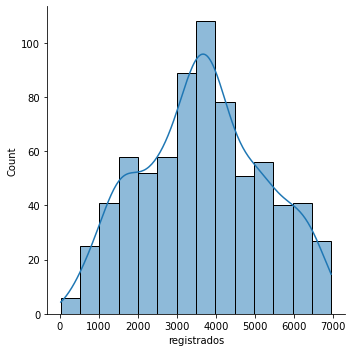

In [35]:
sns.displot(df["registrados"], kde=True)

In [39]:
stats.shapiro(df["registrados"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

Los datos no son normales porque son menores de 0.05

Procedemos a normalizar la variable respuesta

Raiz cuadrada

In [40]:
import math

In [41]:
df["registrados_raiz"] = df["registrados"].apply(lambda x: math.sqrt(x))

In [42]:
stats.shapiro(df["registrados_raiz"])

ShapiroResult(statistic=0.9734106659889221, pvalue=2.97543378824372e-10)

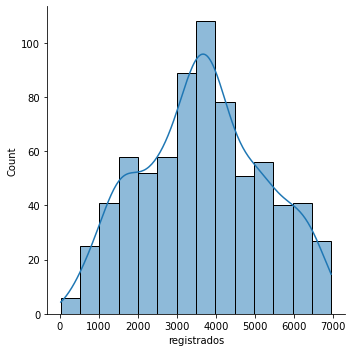

In [43]:
sns.displot(df["registrados"], kde=True)

Box_cox

In [44]:
df['registrados_box'], lambda_ajustada = stats.boxcox(df['registrados'])


In [45]:
stats.shapiro(df["registrados_box"])

ShapiroResult(statistic=0.9854223132133484, pvalue=1.163151068794832e-06)

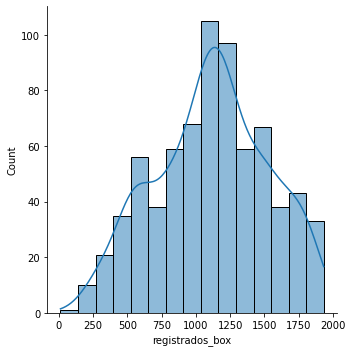

In [46]:
sns.displot(df["registrados_box"], kde=True)